In [5]:
import pandas as pd 
import numpy as np
import random as rd

import seaborn as sns
import matplotlib.pyplot as plt

import time

# Project Machine Learning : Option portfolio hedge

In [7]:
#underlying asset
data=pd.read_csv("NVDA.csv",sep=",",usecols=["Date","Adj Close","Dividends","Stock Splits"])
data["Date"]=pd.to_datetime(data["Date"],format="%Y-%m-%d")
train=data[["Date","Adj Close"]]
train=train[(train["Date"]>="01/01/2015" ) & (train["Date"]<"01/01/2021")]
train=train.rename(columns={"Adj Close":"Price"})

#reference value
S=train["Price"].iloc[0]

## Data Preparation

### Black & Scholes (pricing method)

In [10]:
from scipy.stats import norm

In [11]:
# Computes the price and Greeks (Delta, Gamma, Theta, Vega, Rho) of a European option
# (call or put) using the standard Black-Scholes model. Returns a dictionary with all results.
def option_standard_bl(S,K,r,sigma,T,type):
    if T<=0:
        return {'Price': 0,'Delta': 0,'Gamma': 0,"Theta":0,"Vega":0,"Rho":0}
    d1=(np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    
    if type=="call":
        p=S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
        delta=norm.cdf(d1)
        gamma=norm.pdf(d1)/(S*sigma*np.sqrt(T))
        theta=-(S*norm.pdf(d1)*sigma)/(2*np.sqrt(T))-r*K*np.exp(-r*T)*norm.cdf(d2) 
        vega=S*norm.pdf(d1)*np.sqrt(T)
        rho=K*T*np.exp(-r*T)*norm.cdf(d2)
           
    elif type=="put":
        p=K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)
        #greeks d'un put eu
        delta=norm.cdf(d1)-1 
        gamma=norm.pdf(d1)/(S*sigma*np.sqrt(T))
        theta=-(S*norm.pdf(d1)*sigma)/(2*np.sqrt(T))+r*K*np.exp(-r*T)*norm.cdf(-d2) 
        vega=S*norm.pdf(d1)*np.sqrt(T)
        rho=-K*T*np.exp(-r*T)*norm.cdf(-d2)
    return {'Price': p,'Delta': delta,'Gamma': gamma,"Theta":theta,"Vega":vega,"Rho":rho}

### Portfolio and option set creation

In [13]:
# Generates a random portfolio of European options with random strikes, maturities, types,
# positions (long/short), and quantities, and computes the Delta, Gamma, and Vega for each option.
def portfolio(S,r,sigma,size=5,t_min=0.02):
    p=[]
    for _ in range(size):
        T=rd.uniform(t_min,1.5)
        K=S*rd.uniform(0.8,1.2)
        
        n_type=rd.randint(0,2)
        if n_type==0:
            type="call"
        else:
            type="put"

        n_positon=rd.randint(0,2)
        if n_positon==0:
            position="short"
        else:
            position="long"

        quantity=rd.randint(0,51)
        p.append({"Type":type,"Option_type":"eu","Position":position,"T":T,"K":K,"Quantity":quantity})   
    for opt in p:   
        if opt["Position"]=="longue":
            opt["Delta"]=option_standard_bl(S,opt["K"],r,sigma,opt["T"],opt["Type"])["Delta"]
            opt["Gamma"]=option_standard_bl(S,opt["K"],r,sigma,opt["T"],opt["Type"])["Gamma"]
            opt["Vega"]=option_standard_bl(S,opt["K"],r,sigma,opt["T"],opt["Type"])["Vega"]
        else :
            opt["Delta"]=-option_standard_bl(S,opt["K"],r,sigma,opt["T"],opt["Type"])["Delta"]
            opt["Gamma"]=-option_standard_bl(S,opt["K"],r,sigma,opt["T"],opt["Type"])["Gamma"]
            opt["Vega"]=-option_standard_bl(S,opt["K"],r,sigma,opt["T"],opt["Type"])["Vega"]
    return p
    
# Aggregates the portfolio Greeks by summing Delta, Gamma, and Vega weighted by quantities,
# giving the overall sensitivity of the portfolio to underlying price and volatility changes.
def greeks_p(p):
    p_delta=np.sum([opt["Delta"]*opt["Quantity"] for opt in p])
    p_gamma=np.sum([opt["Gamma"]*opt["Quantity"] for opt in p])
    p_vega=np.sum([opt["Vega"]*opt["Quantity"] for opt in p])
    return p_delta,p_gamma, p_vega

# Computes the total value of a portfolio by summing the prices of each option
# multiplied by their respective quantities
def portfolio_value(S, r,sigma,portfolio):
    total = 0.0
    for opt in portfolio:
        total += opt["Quantity"] * option_standard_bl(S, opt["K"], r, sigma,opt["T"], opt["Type"])["Price"]
    return total

In [14]:
# Generates a hedging portfolio of European options with random strikes, maturities, and types,
# and computes their Delta, Gamma, and Vega. Also adds the underlying asset to the portfolio.
def hedger(S,r,sigma,option_number=6,t_min=0.05): 
    i=[]
    for _ in range(option_number):
        K=S*rd.uniform(0.8,1.2)
        t=rd.uniform(t_min,1.5)
        n_type=rd.randint(0,2)
        if n_type==1:
            type="call"
        else:
            type="put"

        i.append({"Type":type,"Option_type":"eu","T":t,"K":K})
        for h in i:
            h["Delta"]=option_standard_bl(S,h["K"],r,sigma,h["T"],h["Type"])["Delta"]
            h["Gamma"]=option_standard_bl(S,h["K"],r,sigma,h["T"],h["Type"])["Gamma"]
            h["Vega"]=option_standard_bl(S,h["K"],r,sigma,h["T"],h["Type"])["Vega"]
    
    i.append({"Type":"Shares","Option_type":"Underlying asset","Delta":1,"Gamma":0,"Vega":0,"T":0})
    return i

# Extracts the Greeks (Delta, Gamma, Vega) from a hedging portfolio
# and returns them as separate arrays for analysis or risk management.
def greeks_h(h):
    h_delta=np.array([opt["Delta"] for opt in h])
    h_gamma=np.array([opt["Gamma"] for opt in h])
    h_vega=np.array([opt["Vega"] for opt in h])
    return h_delta,h_gamma,h_vega

In [15]:
# Updates the time to maturity and recalculates the Greeks (Delta, Gamma, Vega) 
# for each option in the portfolio to reflect one trading day passing.
def actualisation(S,r,sigma,portfolio):
    for opt in portfolio:
        if opt["Type"]!="Shares":
            opt["T"]=opt["T"]-1/252
            new_p=option_standard_bl(S,opt["K"],r,sigma,opt["T"],opt["Type"])
            opt["Delta"]=new_p["Delta"]
            opt["Gamma"]=new_p["Gamma"]
            opt["Vega"]=new_p["Vega"]

### Optimales position to hedge the portfolio

In [21]:
from scipy.optimize import minimize

In [26]:
# Solves for the hedge portfolio quantities by minimizing a weighted objective 
# combining Delta and Gamma exposure, subject to a Delta-neutral constraint.
def solve_eq(p,h):
    p_delta,p_gamma,p_vega=greeks_p(p)
    h_delta,h_gamma,h_vega=greeks_h(h)

    def objectif(x):
        return (p_gamma + np.dot(h_gamma, x))**2 
    def constrainte(x):
        return p_delta+np.dot(h_delta,x)
        
    cons = ({'type': 'eq', 'fun': constrainte})
    x0 = np.zeros(len(h))
    solution = minimize(objectif, x0, constraints=cons)

    quantites_hedge = solution.x
    return quantites_hedge

### Dataset creation

In [29]:
# Generates a dataset of simulated portfolios and hedging instruments by randomly sampling 
# market parameters and option characteristics. Computes portfolio and hedge Greeks, 
# solves for optimal hedge quantities, and stores features and targets in a DataFrame.

np.random.seed(42) 
start = time.time()
print("Loading in process ..")
N=1000

datafeat = []
dataopt=[]
for i in range(N):
    s=S*rd.uniform(0.8,1.2)
    sigma = rd.uniform(0.05, 0.7)
    r = rd.uniform(0.0, 0.1)

    # simulate a portfolio (ex : 1-3 options random)
    n_opts = np.random.randint(1,4)
    portfolios=portfolio(s,r,sigma,4,t_min=0.5)
    hedgers = hedger(s,r,sigma,6,t_min=0.5)
    
    # compute greeks
    delta_port, gamma_port,vega_port = greeks_p(portfolios)
    H_delta, H_gamma, H_vega = greeks_h(hedgers)
    H_mat=np.array([opt["T"] for opt in hedgers])

    x_opt = solve_eq(portfolios,hedgers) 
    if x_opt is None:
        continue  # skip problematic example
    
  
    Maturity=np.array([opt["T"] for opt in portfolios])
    T_min=Maturity.min()
    T_max=Maturity.max()
    T_mean=Maturity.mean()
    
    # Build feature vector
    feat = [
        s, sigma, r,T_min,T_max,T_mean,
        delta_port, gamma_port,vega_port
    ]
    # append hedgers greeks (delta, gamma)
    for d,g,v,t in zip(H_delta, H_gamma,H_vega,H_mat):
        feat += [d, g,v,t]
    # targets are x_opt (quantities)
    datafeat.append(feat)
    dataopt.append(x_opt)
    if (i%100==0):
        print(i/N)

#colum name
feat_name=["S", "sigma", "r","T_min","T_max","T_mean","Portfolio delta", "Portfolio gamma","Portfolio vega"]
opt_name=[]
for i in range(len(H_gamma)):
    feat_name.append("Delta option "+str(i))
    feat_name.append("Gamma option "+str(i))
    feat_name.append("Vega option "+str(i))
    feat_name.append("T option "+str(i))
for i in range(len(dataopt[0])):
    opt_name.append("x"+str(i))

print("Finished loading !")

df_feats = pd.DataFrame(datafeat, columns=feat_name)  
df_targets = pd.DataFrame(dataopt, columns=opt_name)
df = pd.concat([df_feats, df_targets], axis=1)

end = time.time()
print(f"Execution time : {end - start:.4f} seconds")



Loading in process ..
0.0


KeyboardInterrupt: 

In [1]:
#df.to_parquet("dataset_5000_presentation.parquet")

NameError: name 'df' is not defined

In [31]:
df = pd.read_parquet("dataset_5000_presentation.parquet")

### Data analysis

In [34]:
number_rows=df.shape[0]
number_columns=df.shape[1]
number_values=df.size
names_columns=" ,".join(df.columns)
types_columns=df.dtypes
print(f"We have {number_rows} rows, {number_columns} columns and {number_values} values in the DataFrame.")
print(f"Our columns are called ",names_columns)

We have 5000 rows, 44 columns and 220000 values in the DataFrame.
Our columns are called  S ,sigma ,r ,T_min ,T_max ,T_mean ,Portfolio delta ,Portfolio gamma ,Portfolio vega ,Delta option 0 ,Gamma option 0 ,Vega option 0 ,T option 0 ,Delta option 1 ,Gamma option 1 ,Vega option 1 ,T option 1 ,Delta option 2 ,Gamma option 2 ,Vega option 2 ,T option 2 ,Delta option 3 ,Gamma option 3 ,Vega option 3 ,T option 3 ,Delta option 4 ,Gamma option 4 ,Vega option 4 ,T option 4 ,Delta option 5 ,Gamma option 5 ,Vega option 5 ,T option 5 ,Delta option 6 ,Gamma option 6 ,Vega option 6 ,T option 6 ,x0 ,x1 ,x2 ,x3 ,x4 ,x5 ,x6


In [36]:
l=list(df.isna().sum())
print("Number of element NaN in every column ?")
print(l)
print("So, we don't have values NaN")
print(" Do we have duplicate line ? ", "No" if df.duplicated().sum()==0  else "Yes")


Number of element NaN in every column ?
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
So, we don't have values NaN
 Do we have duplicate line ?  No


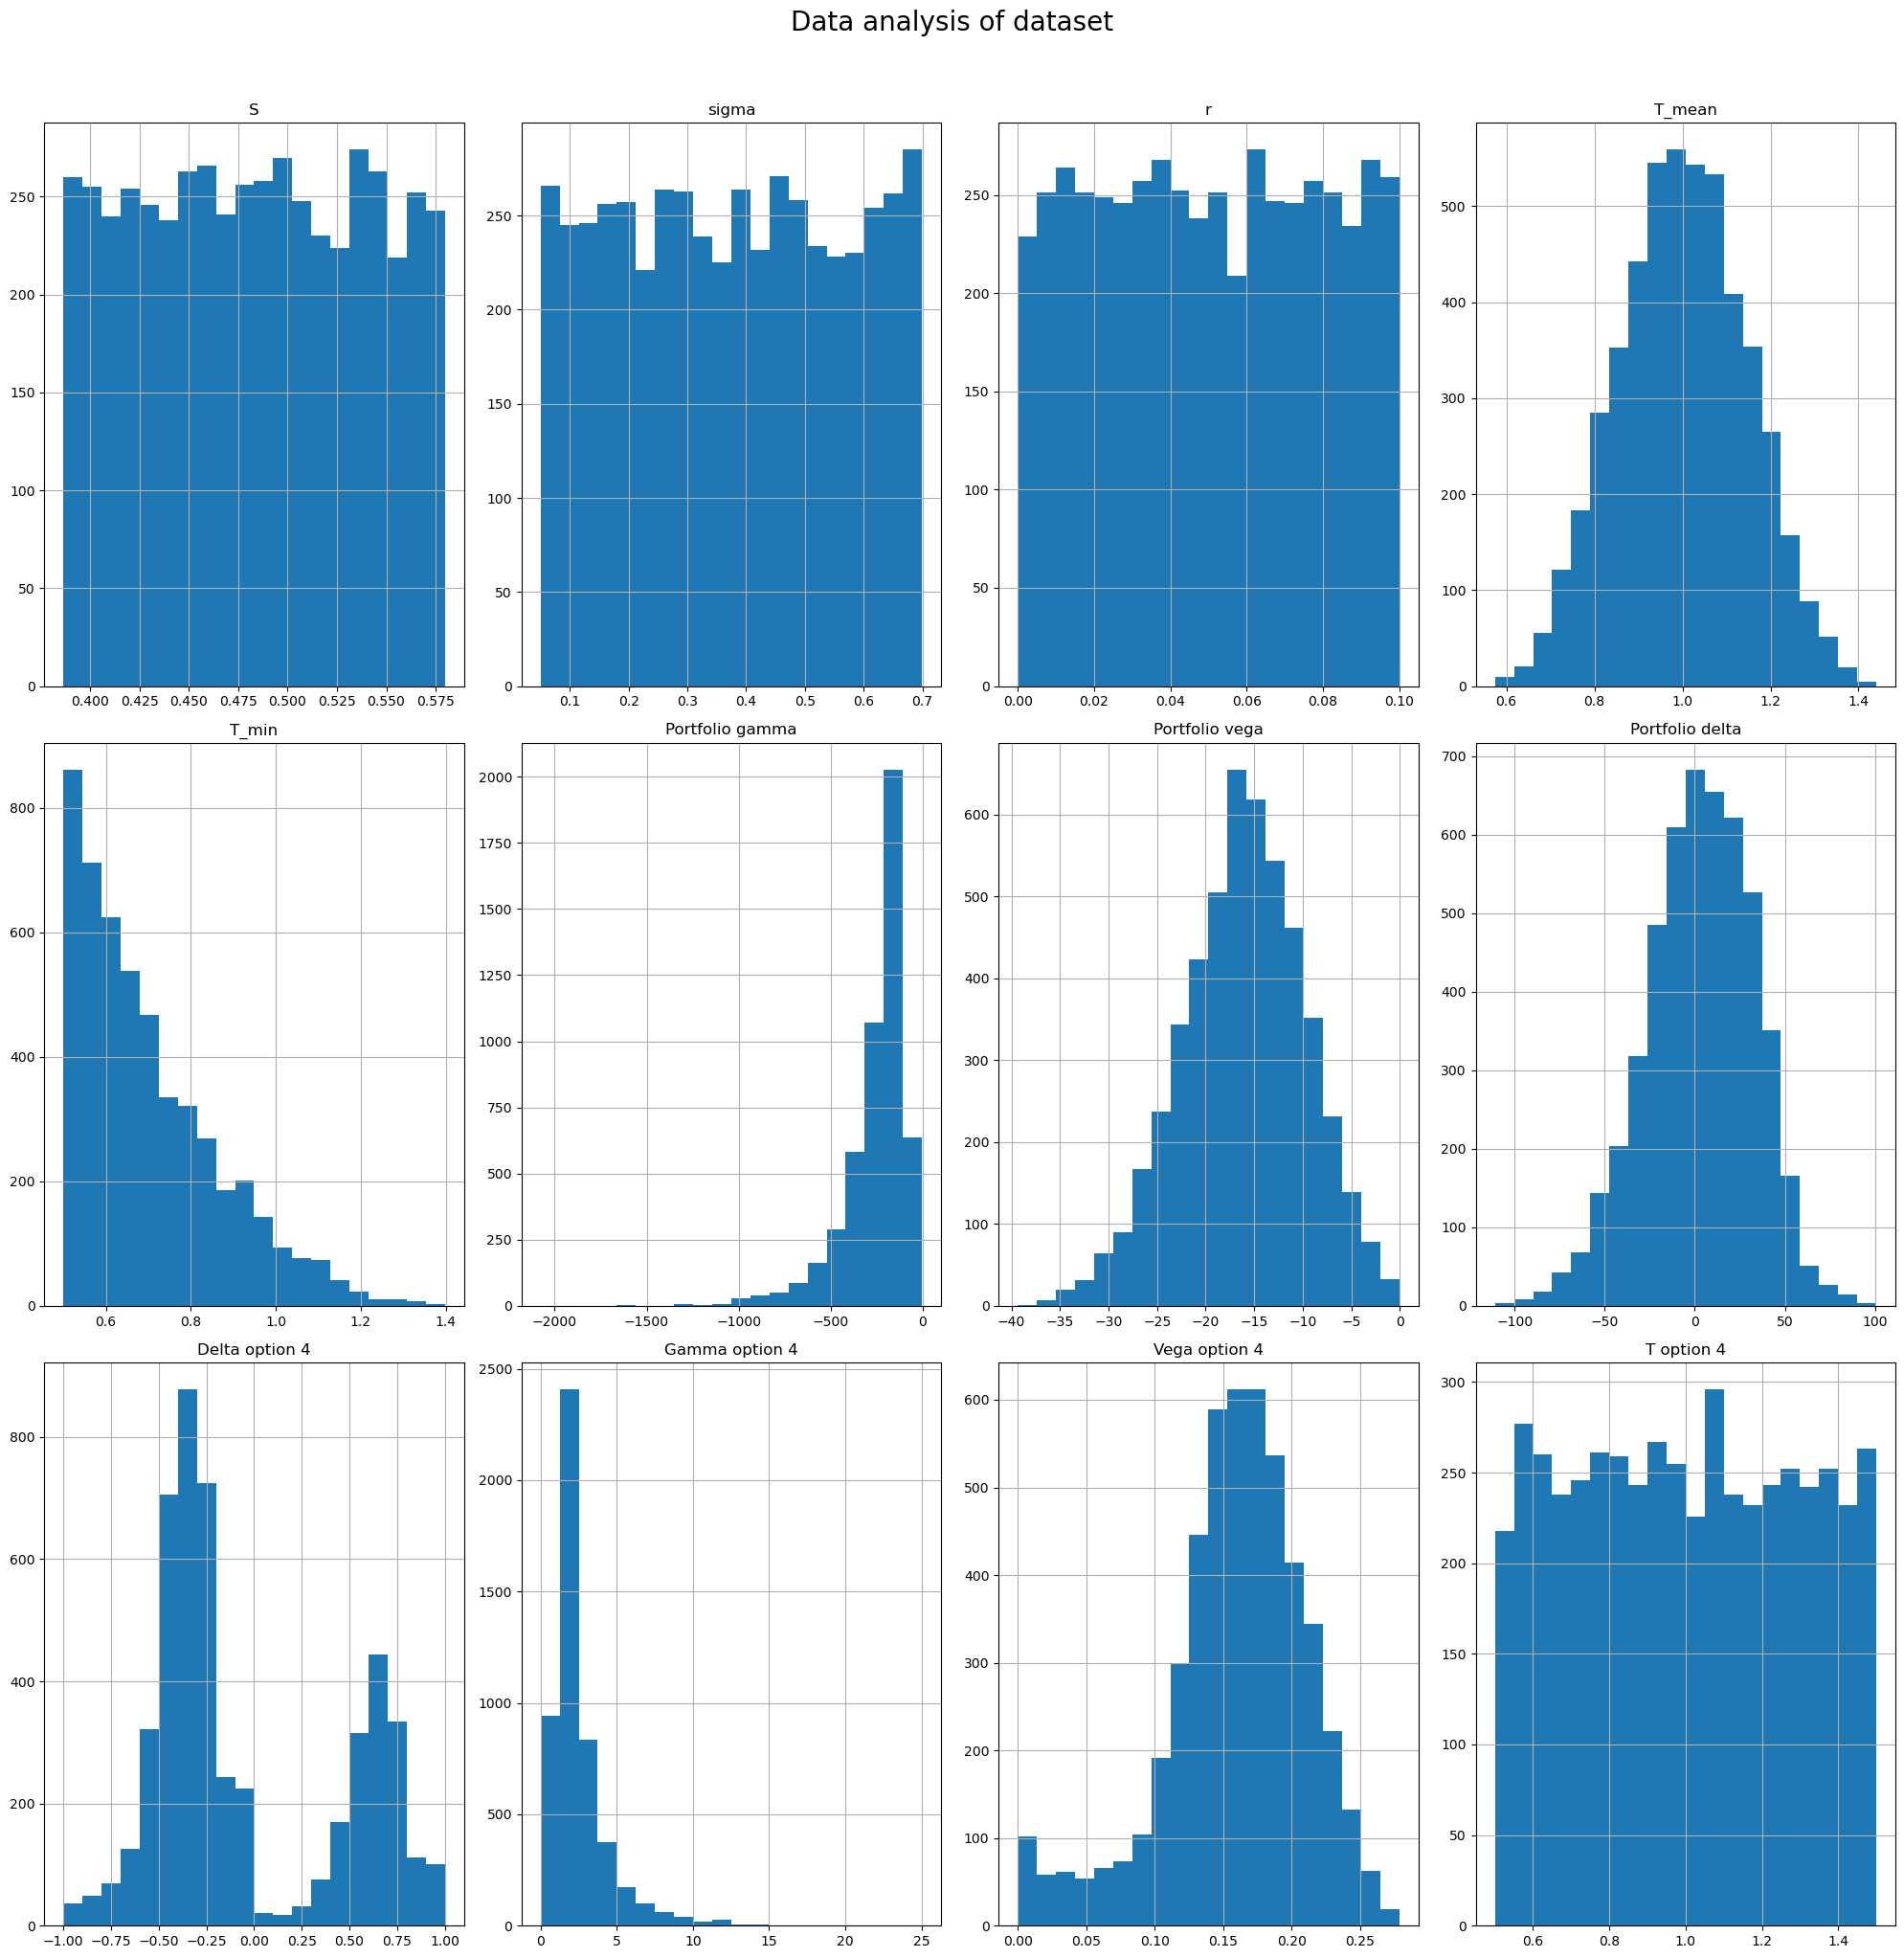

We observe the data for an option in the set


In [38]:
n_columns="4"
names = ["S", "sigma", "r", "T_mean","T_min", "Portfolio gamma", "Portfolio vega", "Portfolio delta",
    "Delta option "+n_columns, "Gamma option "+n_columns, "Vega option "+n_columns, "T option "+n_columns]

plt.figure(figsize=(20, 20))

for i in range(len(names)):
    plt.subplot(3, 4, i+1)
    df[names[i]].hist(bins=20)
    plt.title(names[i])  

plt.suptitle("Data analysis of dataset", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()
print("We observe the data for an option in the set")

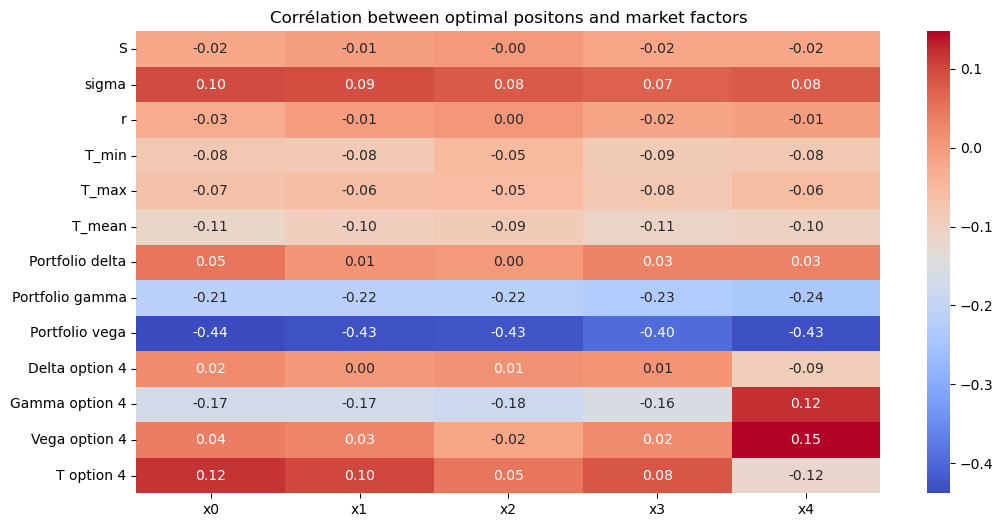

In [40]:
corr_matrix = df.corr()
i=4
feats = ['S', 'sigma', 'r','T_min', 'T_max', 'T_mean', 'Portfolio delta', 'Portfolio gamma', 'Portfolio vega','Delta option '+str(i), 'Gamma option '+str(i),
         'Vega option '+str(i), 'T option '+str(i)]
optimale_positions = ['x0', 'x1', 'x2', 'x3', 'x4']
corr_subset = corr_matrix.loc[feats, optimale_positions]

plt.figure(figsize=(12, 6))
sns.heatmap(corr_subset, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Corrélation between optimal positons and market factors")
plt.yticks(rotation=0)
plt.show()

## Application of machine learning models

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [71]:
X = df.loc[:, "S":"x0"].values[:, :-1]
Y = df.loc[:, "x0":].values

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Multiple linear regression

In [75]:
start = time.time()
# Trains a linear regression model on the training data, predicts the targets on the test set

model_lin = LinearRegression()
model_lin.fit(X_train, y_train)
Y_pred_lin = model_lin.predict(X_test)

end = time.time()
print(f"Execution time : {end - start:.4f} seconds")

Execution time : 1.3010 seconds


In [76]:
mse = mean_squared_error(y_test, Y_pred_lin)
mae = mean_absolute_error(y_test, Y_pred_lin)
r2  = r2_score(y_test, Y_pred_lin)

print("MSE  :", mse)
print("RMSE :", mse**0.5)
print("MAE  :", mae)
print("R²   :", r2)

MSE  : 69.25919191729822
RMSE : 8.322210759004978
MAE  : 5.435693515385337
R²   : 0.4784572200218564


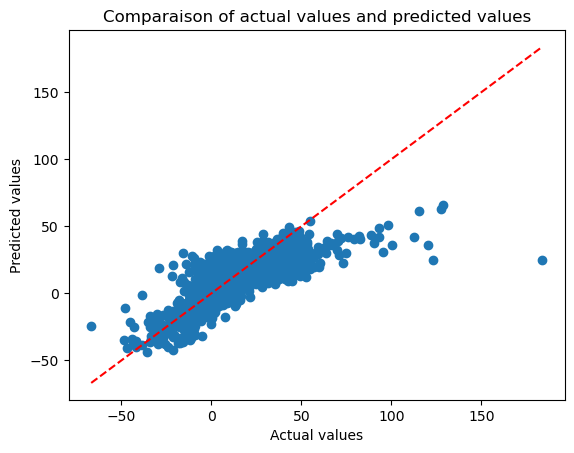

In [79]:
plt.scatter(y_test, Y_pred_lin)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Comparaison of actual values and predicted values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

### Multiple non linear regression

In [ ]:
start = time.time()
# Trains a neural network (MLP) with two hidden layers on the training data, 
# predicts the targets on the test set,

model_nn = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', max_iter=1000)
model_nn.fit(X_train, y_train)
Y_pred_nn = model_nn.predict(X_test)

end = time.time()
print(f"Execution time : {end - start:.4f} seconds")

In [57]:
mse = mean_squared_error(y_test, Y_pred_nn)
mae = mean_absolute_error(y_test, Y_pred_nn)
r2  = r2_score(y_test, Y_pred_nn)
print("MSE  :", mse)
print("RMSE :", mse**0.5)
print("MAE  :", mae)
print("R²   :", r2)

MSE  : 8673.128778024939
RMSE : 93.12963426334788
MAE  : 61.93727732704415
R²   : -78.64517697668256


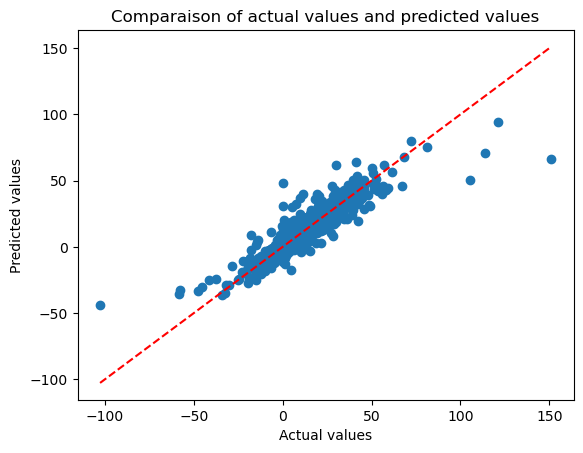

In [57]:
plt.scatter(y_test, Y_pred_nn)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Comparaison of actual values and predicted values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

### Using of GridSearch

In [60]:
from sklearn.model_selection import GridSearchCV

In [66]:
start = time.time()
# Performs hyperparameter tuning for multiple models (Polynomial Regression, Kernel Ridge, SVR, MLP) 
# using GridSearchCV with cross-validation. Stores the best models and their training scores

params_poly = {"poly__degree": [2, 3, 4]}
params_kernel = {"estimator__alpha": [0.1, 1, 10],"estimator__kernel": ["rbf"],"estimator__gamma": [0.01, 0.1, 1]}
params_svr = { "estimator__C": [1, 10, 50],"estimator__gamma": ["scale", 0.1, 1],"estimator__epsilon": [0.01, 0.1]}
param_grid = {"hidden_layer_sizes": [(10,), (50,), (50, 20)], "activation": ["relu", "tanh"],"alpha": [0.0001, 0.001, 0.01],
              "learning_rate_init": [0.001, 0.01]}

pipe_poly = Pipeline([ ("poly", PolynomialFeatures()),("model", LinearRegression())   ])
kernel =  MultiOutputRegressor(KernelRidge())
svr = MultiOutputRegressor(SVR())
mlp = MLPRegressor(max_iter=1000, random_state=42)
   
best_models = {}
results = []

#poly
gs_poly = GridSearchCV(
    estimator=pipe_poly,
    param_grid=params_poly,
    cv=2,
    scoring="neg_mean_squared_error",
    refit=True,
    verbose=1
)
gs_poly.fit(X_train, y_train)
best_models["Poly"] = gs_poly.best_estimator_
results.append(("Poly", -gs_poly.best_score_))

#kernel
gs_kernel = GridSearchCV(
    estimator=kernel,
    param_grid=params_kernel,
    cv=2,
    scoring="neg_mean_squared_error",
    refit=True,
    verbose=1
)
gs_kernel.fit(X_train, y_train)
best_models["KernelRidge"] = gs_kernel.best_estimator_
results.append(("KernelRidge", -gs_kernel.best_score_))

#svr
gs_svr = GridSearchCV(
    estimator=svr,
    param_grid=params_svr,
    cv=2,
    scoring="neg_mean_squared_error",
    refit=True,
    verbose=1
)
gs_svr.fit(X_train, y_train)
best_models["SVR"] = gs_svr.best_estimator_
results.append(("SVR", -gs_svr.best_score_))

#grid
gs_grid = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=2,
    scoring="neg_mean_squared_error",
    refit=True,
    verbose=1
)
gs_grid.fit(X_train, y_train)
best_models["Grid"] = gs_grid.best_estimator_
results.append(("Grid", -gs_grid.best_score_))
end = time.time()
print(f"Execution time : {end - start:.4f} seconds")

Fitting 2 folds for each of 3 candidates, totalling 6 fits
Fitting 2 folds for each of 9 candidates, totalling 18 fits
Fitting 2 folds for each of 18 candidates, totalling 36 fits
Fitting 2 folds for each of 36 candidates, totalling 72 fits


C:\Users\bours\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bours\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bours\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bours\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bours\anaconda3\Lib\site-packages\sklearn\neural_network\_m

Execution time : 171.1187 seconds


C:\Users\bours\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


### Overfiting / Underfiting

In [70]:
# Evaluates each best model on training and test sets by computing MSE and R²,
# prints the results, and flags potential overfitting or underfitting based on 
# differences between train/test metrics and threshold values.

thresholdR=0.1
thresholdMse=0.5
for name, model in best_models.items():
    # Performance sur train
    y_train_pred = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    
    # Performance sur test
    y_test_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    print(f"{name}:")
    print(f"  Train -> MSE = {mse_train:.4f}, R2 = {r2_train:.4f}")
    print(f"  Test  -> MSE = {mse_test:.4f}, R2 = {r2_test:.4f}\n")
    print("Maybe overfitting" if (((abs(mse_test-mse_train)>thresholdMse or abs(r2_test-r2_train)>thresholdR ) and r2_test>0.6)or r2_train==1) else "I think there is no overfitting")
    print("Maybe underfitting " if r2_test<0.5 else "I think there is no underfitting")

Poly:
  Train -> MSE = 0.0000, R2 = 1.0000
  Test  -> MSE = 127.4106, R2 = 0.2783

Maybe overfitting
Maybe underfitting 
KernelRidge:
  Train -> MSE = 10.2158, R2 = 0.9278
  Test  -> MSE = 52.3924, R2 = 0.7082

Maybe overfitting
I think there is no underfitting
SVR:
  Train -> MSE = 2.8962, R2 = 0.9876
  Test  -> MSE = 62.5737, R2 = 0.6713

Maybe overfitting
I think there is no underfitting
Grid:
  Train -> MSE = 7.9857, R2 = 0.9402
  Test  -> MSE = 46.7892, R2 = 0.7520

Maybe overfitting
I think there is no underfitting


if there is overfitting, a solution is using more data or using less dimension

In [72]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: MSE = {mse:.4f}, R2 = {r2:.4f}")

Poly: MSE = 127.4106, R2 = 0.2783
KernelRidge: MSE = 52.3924, R2 = 0.7082
SVR: MSE = 62.5737, R2 = 0.6713
Grid: MSE = 46.7892, R2 = 0.7520


### Using vote 

We can't use VotingRegression because the variable y has more one dimension, so we use the mean

In [78]:
# Implements a hybrid model by averaging predictions from Grid (MLP), Kernel Ridge, and SVR,
# then evaluates the combined predictions on the test set using MSE and R² metrics.
def predict(X):
    y_pred_grid = best_models["Grid"].predict(X)
    y_pred_kernel = best_models["KernelRidge"].predict(X)
    y_pred_svr = best_models["SVR"].predict(X)
    return  (y_pred_grid + y_pred_kernel + y_pred_svr) / 3


mse = mean_squared_error(y_test, predict(X_test))
r2 = r2_score(y_test, predict(X_test))
print(f"Hybrid Model (mean of 3 models): MSE = {mse:.4f}, R2 = {r2:.4f}")

Hybrid Model (mean of 3 models): MSE = 45.3123, R2 = 0.7591


## Visualizations of results on one year

In [81]:
# Returns the last `n_days` of the underlying asset's spot prices from the training data,
# raising an error if there are not enough data points available.
def get_spot_path(n_days=252):
    spot=train["Price"]
    if len(spot) >= n_days:
        return spot[-n_days:]
    else :
        raise ValueError("Error, there is not enough data")

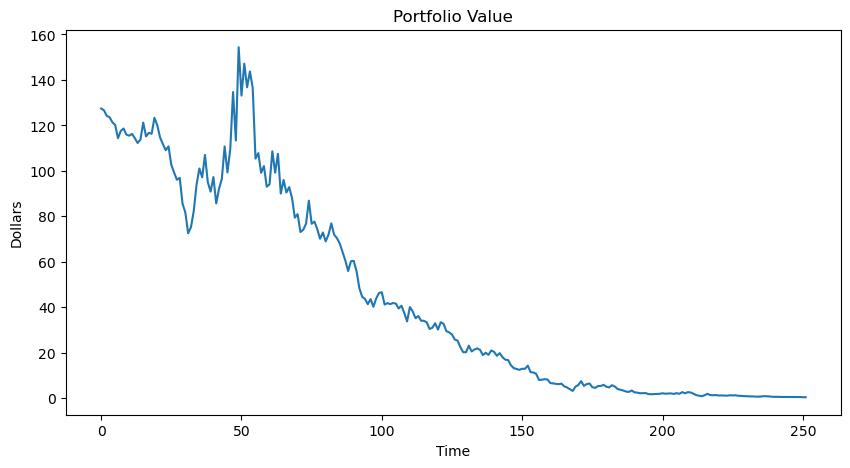

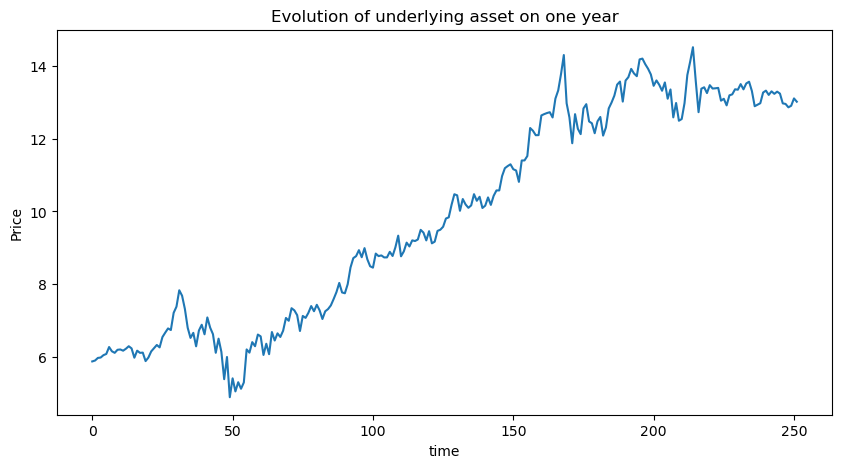

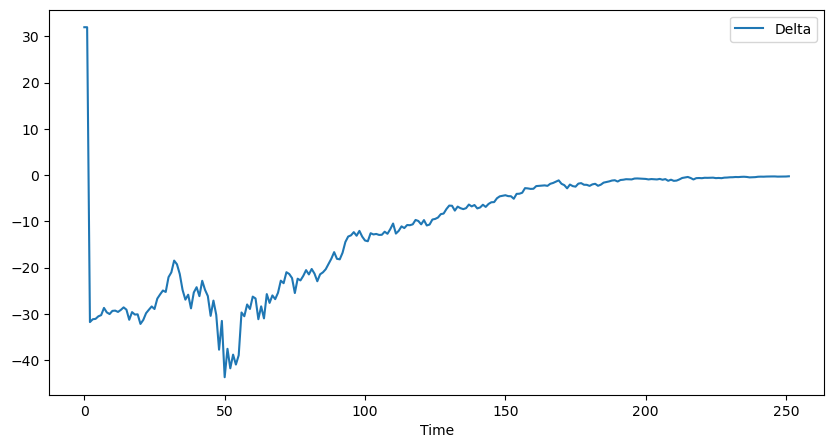

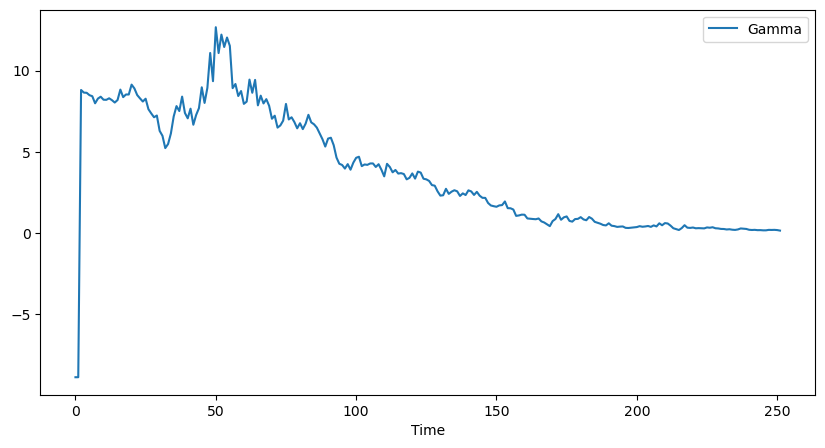

Execution time : 6.1776 seconds


In [83]:
# Simulates the daily evolution of a portfolio and its hedging instruments over a given spot price series.
# Computes portfolio value and Greeks (Delta, Gamma, Vega) each day, predicts hedge adjustments using the hybrid model,
# updates option maturities, and plots the evolution of the portfolio, underlying asset, and Greeks over time.

start = time.time()
r = 0.01             
sigma = 0.6      
spot_series = get_spot_path()
S_init = spot_series.iloc[0]
n_days = len(spot_series) 

portfolios=portfolio(S_init,r,sigma,size=4,t_min=1)
hedge=hedger(S_init,r,sigma,option_number=6,t_min=1)
delta_p,gamma_p,vega_p = greeks_p(portfolios)

init_value = portfolio_value(S_init,r,sigma, portfolios)

evolution_portfolio=[init_value]
evolution_delta=[delta_p]
evolution_gamma=[gamma_p]
evolution_vega=[vega_p]

prediction=[]

for t in range(1,n_days):
    St=spot_series.iloc[t]
    evolution_portfolio.append(portfolio_value(St,r,sigma,portfolios))

    delta_p,gamma_p,vega_p = greeks_p(portfolios)

    evolution_delta.append(delta_p)
    evolution_gamma.append(gamma_p)
    evolution_vega.append(vega_p)

    maturity=[]
    for opt in portfolios:
        maturity.append(max(opt["T"],0))
    T_max=np.max(maturity)
    T_min=np.min(maturity)
    T_mean=np.mean(maturity)
    feature_market=[St,sigma,r,T_min,T_max,T_mean,delta_p,gamma_p,vega_p]


    delta_h,gamma_h,vega_h=greeks_h(hedge)
    maturity2=[ opt["T"] for opt in hedge]
    feature_hedge=[]
    for i in range(len(hedge)):
        feature_hedge.append(delta_h[i])
        feature_hedge.append(gamma_h[i])
        feature_hedge.append(vega_h[i])
        feature_hedge.append(maturity2[i])


    feature=feature_market+feature_hedge

    prediction.append(predict(np.array(feature).reshape(1, -1)))


    actualisation(St,r,sigma,portfolios)
    actualisation(St,r,sigma,hedge)

t1=range(n_days)
plt.figure(figsize=(10,5))
plt.plot(t1,evolution_portfolio)
plt.title("Portfolio Value")
plt.xlabel("Time")
plt.ylabel("Dollars")
plt.show()

plt.figure(figsize=(10,5))
plt.plot (t1,spot_series)
plt.title("Underlying asset price")
plt.xlabel("time")
plt.ylabel("Price")
plt.title("Evolution of underlying asset on one year")
plt.show()

plt.figure(figsize=(10,5))
plt.plot (t1,evolution_delta, label="Delta")
plt.xlabel("Time")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot (t1,evolution_gamma, label="Gamma")
plt.xlabel("Time")
plt.legend()
plt.show()
end = time.time()
print(f"Execution time : {end - start:.4f} seconds")

Shape finale de prediction_array : (251, 7)


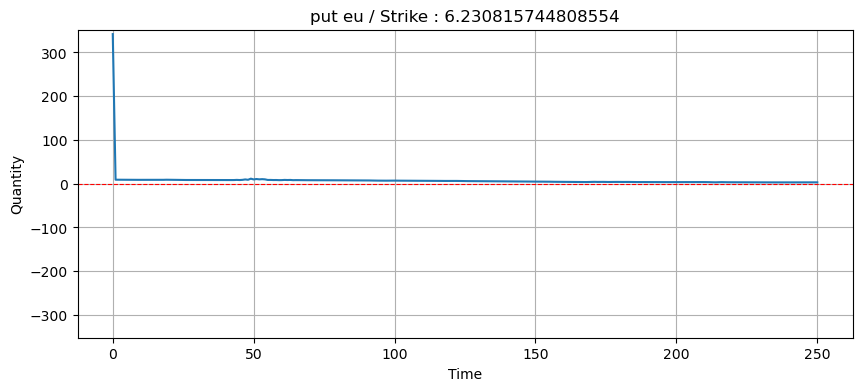

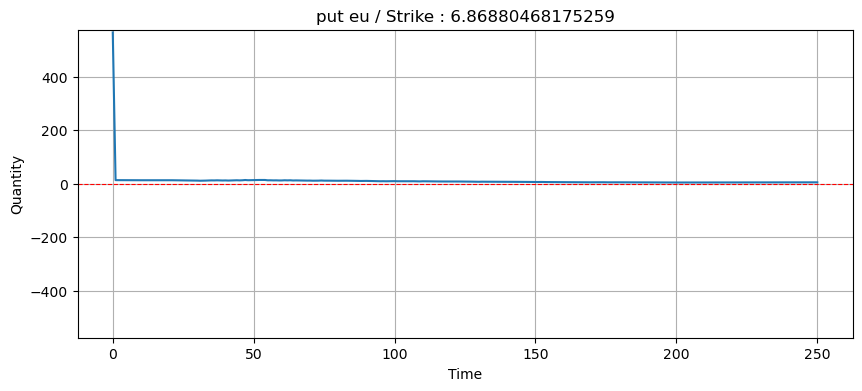

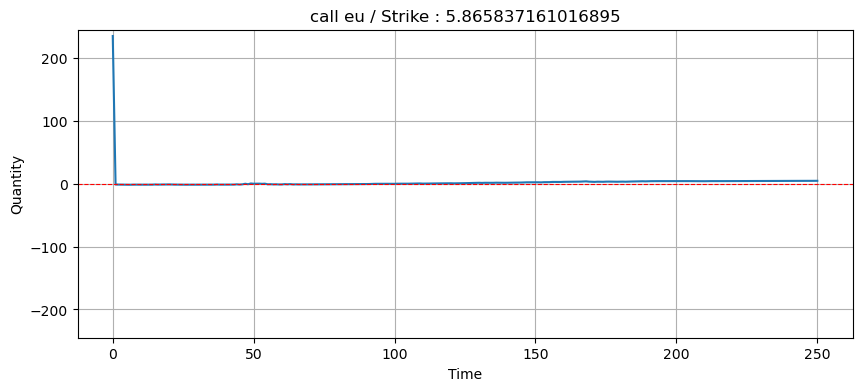

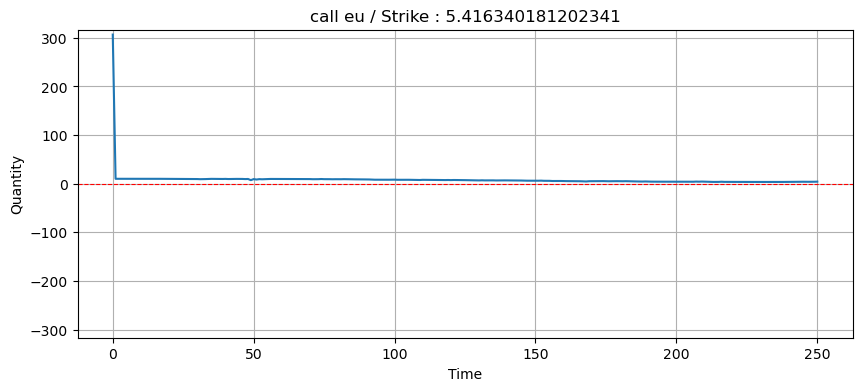

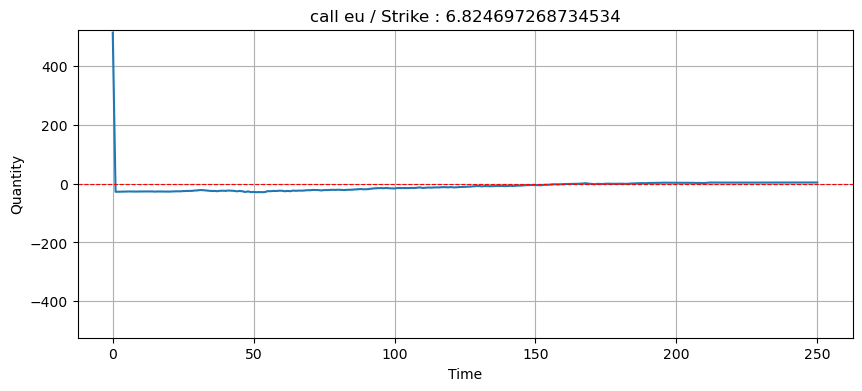

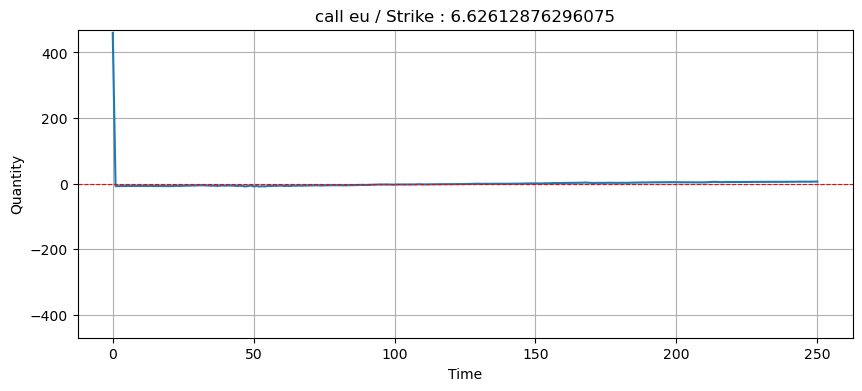

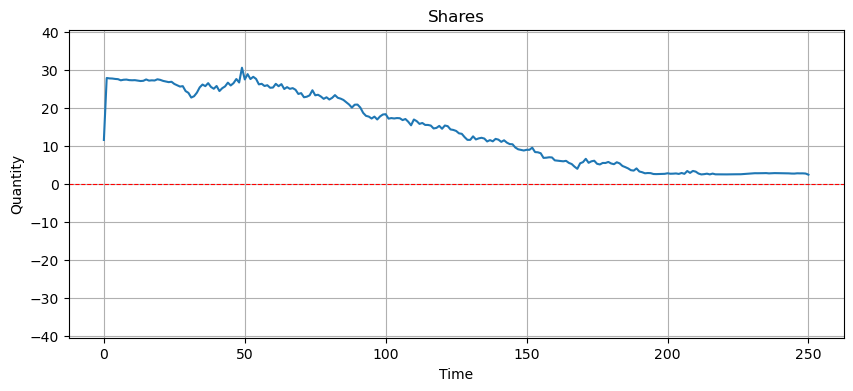

In [84]:
# Converts the predicted hedge quantities into an array and plots the evolution of each option's 
# hedge quantity over time, with a symmetric Y-axis around zero and a reference line at zero.

prediction_array = np.array([p[0] for p in prediction])
print("Shape finale de prediction_array :", prediction_array.shape)  # (251, 13)

t = range(prediction_array.shape[0])
n_options = prediction_array.shape[1]

for i in range(n_options):
    option = hedge[i]
    if option["Type"]!="Shares":
        name = option["Type"] + " " + option["Option_type"]+" / Strike : "+str(option["K"])
    else:
        name=option["Type"]
    valeurs = prediction_array[:, i]

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(t, valeurs)
    ax.set_xlabel("Time")
    ax.set_ylabel("Quantity")
    ax.set_title(name)
    
    max_abs = np.max(np.abs(valeurs))+10
    # Axis Y symetrical around 0
    ax.set_ylim(-max_abs, max_abs)

    ax.axhline(0,color="red",linewidth=0.8,linestyle="--")
    
    ax.grid()

    display(fig)
    plt.close(fig)
    